In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

df = pd.read_excel('daily-minimum-temperatures-in-me.xls')
dataframe = pd.concat([df.temperature.shift(4), df.temperature], axis=1).dropna()
dataframe.columns = ['x', 'y']

xtrain, xtest, ytrain, ytest = train_test_split(dataframe.x, dataframe.y, shuffle=False, test_size=0.1)
x_train = xtrain.values.reshape(-1, 1)
x_test = xtest.values.reshape(-1,1)

svm = SVR(gamma=0.1)
svm.fit(x_train, ytrain)
svm.score(x_test, ytest)

0.3959192362920442

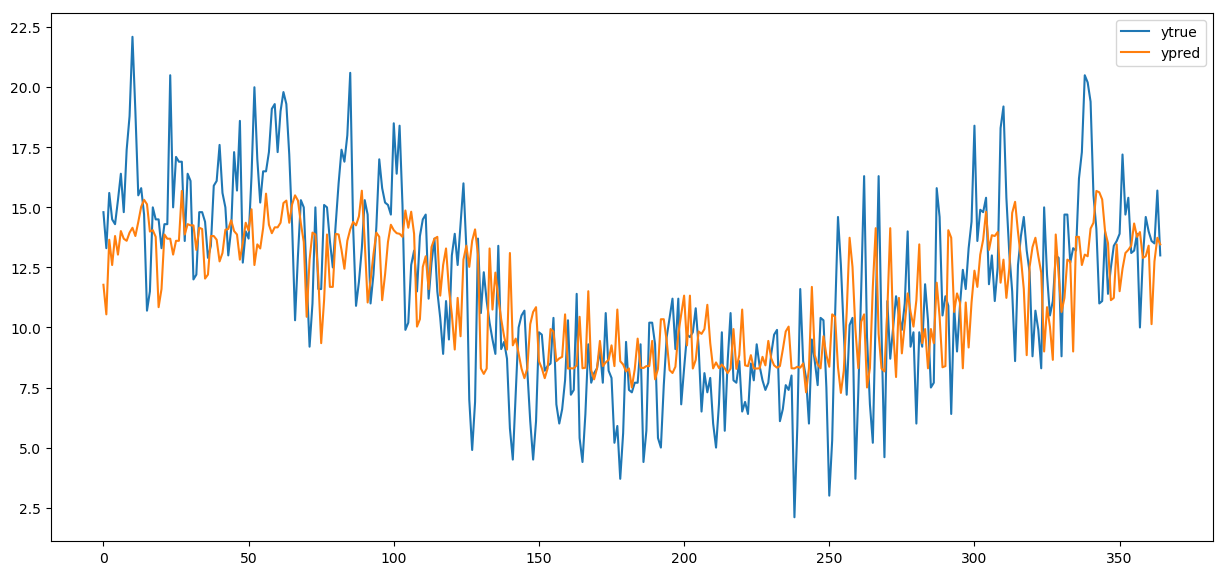

In [2]:
ypred = svm.predict(x_test)

fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [3]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=1))
model.add(Dense(units=1, activation='relu'))
model.compile(loss='mse',
              optimizer='sgd')

model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)

/home/felipe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/50
 - 1s - loss: 140.2286
Epoch 2/50
 - 0s - loss: 140.2286
Epoch 3/50
 - 0s - loss: 140.2286
Epoch 4/50
 - 0s - loss: 140.2286
Epoch 5/50
 - 0s - loss: 140.2286
Epoch 6/50
 - 0s - loss: 140.2286
Epoch 7/50
 - 0s - loss: 140.2286
Epoch 8/50
 - 0s - loss: 140.2286
Epoch 9/50
 - 0s - loss: 140.2286
Epoch 10/50
 - 0s - loss: 140.2286
Epoch 11/50
 - 0s - loss: 140.2286
Epoch 12/50
 - 0s - loss: 140.2286
Epoch 13/50
 - 0s - loss: 140.2286
Epoch 14/50
 - 0s - loss: 140.2286
Epoch 15/50
 - 0s - loss: 140.2286
Epoch 16/50
 - 0s - loss: 140.2286
Epoch 17/50
 - 0s - loss: 140.2286
Epoch 18/50
 - 0s - loss: 140.2286
Epoch 19/50
 - 0s - loss: 140.2286
Epoch 20/50
 - 0s - loss: 140.2286
Epoch 21/50
 - 0s - loss: 140.2286
Epoch 22/50
 - 0s - loss: 140.2286
Epoch 23/50
 - 0s - loss: 140.2286
Epoch 24/50
 - 0s - loss: 140.2286
Epoch 25/50
 - 0s - loss: 140.2286
Epoch 26/50
 - 0s - loss: 140.2286
Epoch 27/50
 - 0s - loss: 140.2286
Epoch 28/50
 - 0s - loss: 140.2286
Epoch 29/50
 - 0s - loss: 140